In [1]:
import spatialdata as sd
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from spatialdata import get_extent
from spatialdata import bounding_box_query
from spatialdata import match_element_to_table
import spatialdata_plot
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from datatree import DataTree
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine
from sklearn.neighbors import KernelDensity
from easydecon.easydecon import *
from easydecon.config import *
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent



pd.set_option('display.max_rows', 500)

/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
set_n_jobs(5) #if you have more than 5 cores, you can increase this number

In [2]:
# load a compatible color map for the spatial data
new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")

Now we load the spatial data and the target data. We use 8um bin size which is an acceptable resolution. Set the sample id and point spaceranger output directory.

In [3]:
bin_size=8
sample_id="sampleP2"

sdata=spatialdata_io.visium_hd("../../sampleP2/binned_outputs/",fullres_image_file="../../sampleP2/Visium_HD_Human_Colon_Cancer_tissue_image.btf",
                               bin_size=bin_size,dataset_id=sample_id,load_all_images=True)
sdata

/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object
├── Images
│     ├── 'sampleP2_cytassist_image': DataArray[cyx] (3, 3000, 3200)
│     ├── 'sampleP2_full_image': DataTree[cyx] (3, 48740, 75250), (3, 24370, 37625), (3, 12185, 18812), (3, 6092, 9406), (3, 3046, 4703)
│     ├── 'sampleP2_hires_image': DataArray[cyx] (3, 3886, 6000)
│     └── 'sampleP2_lowres_image': DataArray[cyx] (3, 389, 600)
├── Shapes
│     └── 'sampleP2_square_008um': GeoDataFrame shape: (545913, 1) (2D shapes)
└── Tables
      └── 'square_008um': AnnData (545913, 18085)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        sampleP2_hires_image (Images), sampleP2_square_008um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        sampleP2_lowres_image (Images), sampleP2_square_008um (Shapes)
    ▸ 'global', with elements:
        sampleP2_cytassist_image (Images), sampleP2_full_image (Images), sampleP2_square_008um (Shapes)

In [4]:
# to align the high resolution image with the spatial data, we need to run this part
data_extent=get_extent(sdata[f"{sample_id}_square_00{bin_size}um"])

queried_cytassist = bounding_box_query(
    sdata[f"{sample_id}_full_image"],
    min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
    max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
    axes=("x", "y"),
    target_coordinate_system="global",
)

sdata["queried_cytassist"]=queried_cytassist

We need to normalize the data before running the spatial deconvolution. We will use the normalization method from scanpy. We can also add the qc metrics.

In [5]:
for table in sdata.tables.values():
   table.var_names_make_unique()
   sc.pp.calculate_qc_metrics(table, inplace=True)
   sc.pp.filter_genes(table, min_cells=3)
   sc.pp.filter_cells(table, min_counts=1)
   sc.pp.normalize_total(table, inplace=True,target_sum=1e4)
   sc.pp.log1p(table)
   #sc.pp.scale(table)
   #sc.pp.pca(table)
   #sc.pp.neighbors(table)
   #sc.tl.umap(table)

#here we filter the spatial data to only include the cells that are in the table
sdata.shapes[f"{sample_id}_square_00{bin_size}um"]=sdata.shapes[f"{sample_id}_square_00{bin_size}um"][sdata.shapes[f"{sample_id}_square_00{bin_size}um"].index.isin(sdata.tables[f"square_00{bin_size}um"].obs["location_id"])]

/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `sampleP2_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Now visualize the full image and the expressed region. "queried_cytassist" image that we created before can be used to visualize the expressed region.

INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   


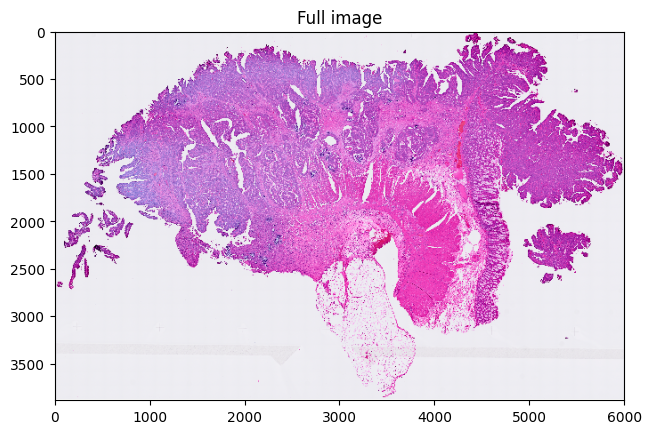

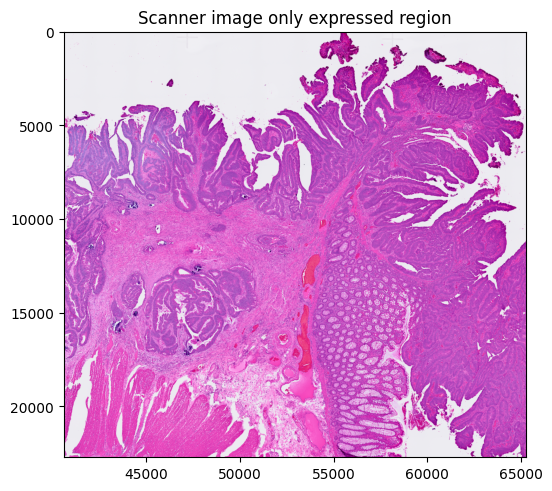

In [6]:
sdata.pl.render_images(f"{sample_id}_hires_image").pl.show( title="Full image")
sdata.pl.render_images("queried_cytassist").pl.show( title="Scanner image only expressed region")



We can run Easydecon on the subregion of the data. We also also use the entire section to run the spatial deconvolution but it is faster to run on the region of interest.
Lets select a subregion. You can check the coordinates of the region of interest from the image above.

In [7]:
sdata_small = sdata.query.bounding_box(
   min_coordinate=[42000, 12000], max_coordinate=[50000, 18000], axes=("x", "y"), target_coordinate_system="global"
)

In [8]:
#sdata_small is the region of interest, as you see it is smaller than the full sdata object.
sdata_small

SpatialData object
├── Images
│     ├── 'queried_cytassist': DataTree[cyx] (3, 6000, 8000), (3, 3000, 4001), (3, 1500, 2000), (3, 750, 1000), (3, 375, 500)
│     ├── 'sampleP2_cytassist_image': DataArray[cyx] (3, 364, 483)
│     └── 'sampleP2_full_image': DataTree[cyx] (3, 6000, 8000), (3, 3000, 4000), (3, 1500, 2000), (3, 750, 1000), (3, 375, 500)
├── Shapes
│     └── 'sampleP2_square_008um': GeoDataFrame shape: (56778, 1) (2D shapes)
└── Tables
      └── 'square_008um': AnnData (56778, 18058)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        sampleP2_square_008um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        sampleP2_square_008um (Shapes)
    ▸ 'global', with elements:
        queried_cytassist (Images), sampleP2_cytassist_image (Images), sampleP2_full_image (Images), sampleP2_square_008um (Shapes)

Here we load the Anndata file from Pelka study. We will use this data for deconvolution.

In [9]:
adata=sc.read_h5ad('/Users/sium/projects/visiumhd/scrna/pelka/allcels/adata3.h5ad')
adata

AnnData object with n_obs × n_vars = 371223 × 43282
    obs: 'X', 'Y', 'ClusterFull', 'ClusterMidway', 'ClusterTop', 'celltype'
    uns: 'celltype_colors', 'dendrogram_ClusterTop', 'dendrogram_celltype', 'pca', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs'

Now reading the marker genes from the Pelka study. We will use these genes for deconvolution. We will use the top 60 genes per cluster.

In [10]:
markers_df_top60lf=read_markers_dataframe(sdata_small,adata=adata,top_n_genes=60,sort_by_column='logfoldchanges')

#markers_df_top60lf is the dataframe that contains the top 60 genes that are differentially expressed in the Pelka study.
markers_df_top60lf.index.value_counts()

Unique cell types detected in the dataframe:
['Mast', 'Plasma', 'Strom', 'Myeloid', 'B', 'TNKILC', 'Epi']
Categories (7, object): ['B', 'Epi', 'Mast', 'Myeloid', 'Plasma', 'Strom', 'TNKILC']


/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/easydecon/easydecon.py:251: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(celltype).head(top_n_genes)


group
B          60
Epi        60
Mast       60
Myeloid    60
Plasma     60
Strom      60
TNKILC     60
Name: count, dtype: int64

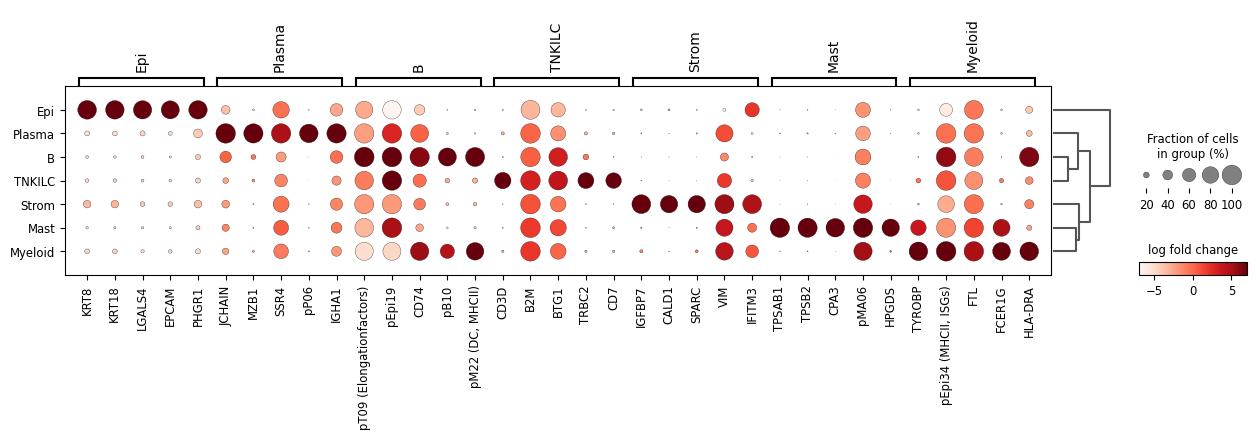

In [11]:
#we can now plot the top 5 genes in the adata object
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5,values_to_plot="logfoldchanges",    vmax=7,
    vmin=-7)

Now we run the mean gene expression for the selected region. This will return a dataframe with the mean gene expression for the selected region and this data will automatically be added to the spatial data object i.e. sdata_small.

In [12]:
df_cluster_mean=get_clusters_expression_on_tissue(sdata_small,markers_df=markers_df_top60lf,method="mean")

common_group_name column not found in the table, processing all spots.


Processing spots:   0%|          | 0/56778 [00:00<?, ?it/s]/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/easydecon/easydecon.py:295: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.26903933]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[spot] = pd.DataFrame.from_dict(a, orient='index').transpose().values
/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/easydecon/easydecon.py:295: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.08793764]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[spot] = pd.DataFrame.from_dict(a, orient='index').transpose().values
/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/easydecon/easydecon.py:295: FutureWarning: Setting an

In [13]:
#the dataframe looks like this. The columns are the clusters and the rows are the spatial bins.
df_cluster_mean.head()

group                      Mast    Plasma     Strom   Myeloid         B  \
s_008um_00282_00228-1  0.000000  0.000000  0.000000  0.000000  0.000000   
s_008um_00196_00202-1  0.000000  0.087938  0.043969  0.000000  0.043969   
s_008um_00285_00131-1  0.000000  0.000000  0.000000  0.000000  0.000000   
s_008um_00311_00071-1  0.000000  0.000000  0.103114  0.051557  0.051557   
s_008um_00219_00193-1  0.054024  0.108047  0.108047  0.281342  0.144078   

group                    TNKILC       Epi  
s_008um_00282_00228-1  0.000000  0.269039  
s_008um_00196_00202-1  0.000000  0.186821  
s_008um_00285_00131-1  0.000000  0.309179  
s_008um_00311_00071-1  0.000000  0.165842  
s_008um_00219_00193-1  0.108047  0.108047

We can visualize any cluster we can, for example Epithelial cells.

INFO     Using matplotlib                                                                                          


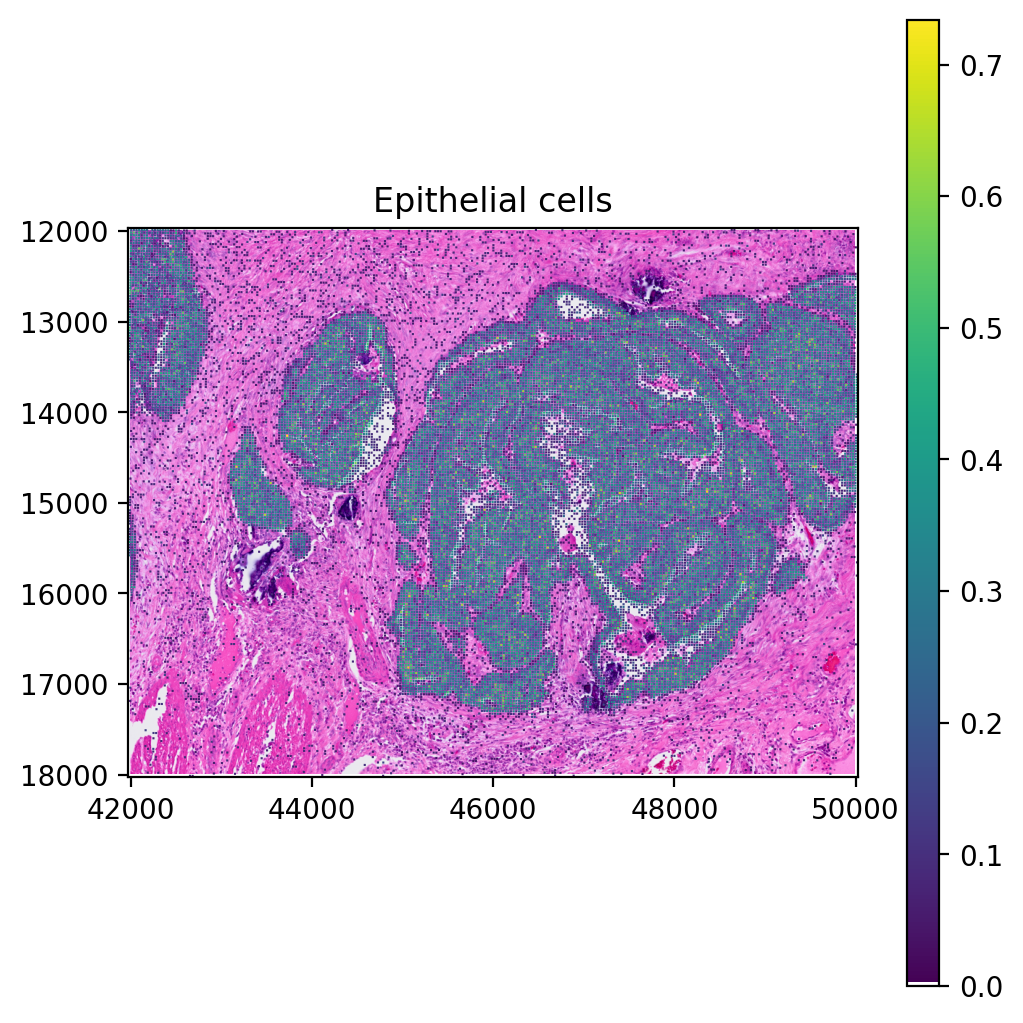

In [14]:
sdata_small.pl.render_images("queried_cytassist").pl.render_shapes(
            f"{sample_id}_square_00{bin_size}um", color="Epi",cmap=new_cmap,method="matplotlib",scale=0.8
        ).pl.show(coordinate_systems="global", title="Epithelial cells",legend_fontsize=8,figsize=(5,5),dpi=200)


It is also possible to predict clusters based on the mean gene expression. The function will return the predicted clusters and write into the spatial data object, column **easydecon_mean_clusters**.

In [15]:
assign_clusters_from_df(sdata_small,df_cluster_mean,results_column="easydecon_mean_clusters")

<Axes: title={'center': 'Cluster distribution'}, xlabel='easydecon_mean_clusters'>

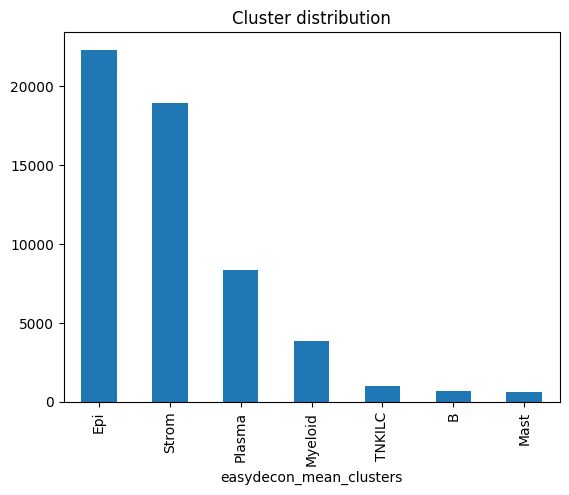

In [16]:
sdata_small.tables["square_008um"].obs['easydecon_mean_clusters'].value_counts().plot(kind='bar',title='Cluster distribution')
#Here we see the distribution of the clusters in the spatial data. Epithelial cells are the most abundant while mast cells are the least.

It is also possible to visaualize the predicted clusters on the region of interest.

INFO     Using matplotlib                                                                                          


/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:719: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


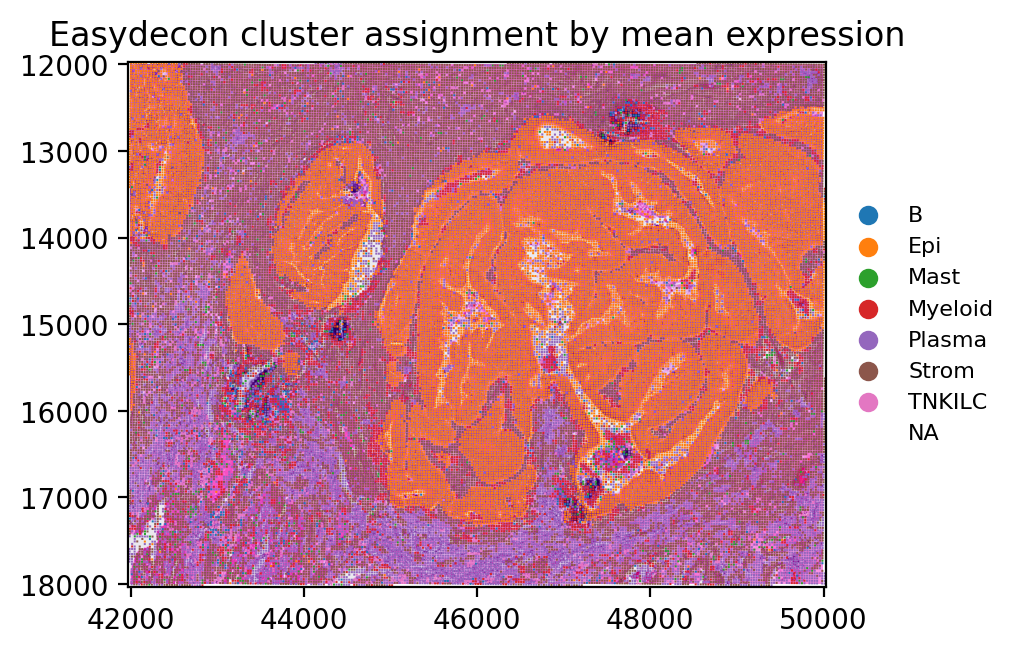

In [17]:
sdata_small.pl.render_images("queried_cytassist").pl.render_shapes(
            f"{sample_id}_square_00{bin_size}um", color="easydecon_mean_clusters",method="matplotlib",scale=0.8,na_color= (0.0, 0.0, 0.0, 0.0)
        ).pl.show(coordinate_systems="global", title="Easydecon cluster assignment by mean expression", legend_fontsize=8,figsize=(5,5),dpi=200)


We can also use a different methods. This time rather than mean gene expression, we will use a similarity metric called weighted-Jaccard.

In [18]:
df_cluster_wjaccard=get_clusters_by_similarity_on_tissue(sdata_small,markers_df=markers_df_top60lf,method="wjaccard")

common_group_name column not found in the table, processing all spots.
Method: Weighted Jaccard similarity
Number of threads used: 5
Batch size: 1000


  9%|▉         | 5010/56778 [00:22<03:39, 236.25it/s]/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/joblib/externals/loky/process_execu

In [19]:
# data frame is similar to the mean expression one.
df_cluster_wjaccard.head()

Mast    Plasma         Strom       Myeloid  \
s_008um_00282_00228-1  0.000000e+00  0.000000  0.000000e+00  0.000000e+00   
s_008um_00196_00202-1  0.000000e+00  0.001433  1.103366e-08  0.000000e+00   
s_008um_00285_00131-1  0.000000e+00  0.000000  0.000000e+00  0.000000e+00   
s_008um_00311_00071-1  0.000000e+00  0.000000  6.040843e-08  4.123230e-15   
s_008um_00219_00193-1  2.849521e-13  0.002754  7.677578e-08  1.687300e-03   

                                  B    TNKILC       Epi  
s_008um_00282_00228-1  0.000000e+00  0.000000  0.002162  
s_008um_00196_00202-1  4.944944e-08  0.000000  0.001643  
s_008um_00285_00131-1  0.000000e+00  0.000000  0.001913  
s_008um_00311_00071-1  6.040829e-08  0.000000  0.000184  
s_008um_00219_00193-1  7.677578e-08  0.000228  0.000378

The latest method is automatically added to the spatial data object. However, we can add it manually as well using add_df_to_spatialdata function. This will replace the identical columns with the new data.

In [20]:
add_df_to_spatialdata(sdata_small,df_cluster_wjaccard)

DataFrame added to SpatialData object
                       in_tissue  array_row  array_col  location_id  \
s_008um_00282_00228-1          1        282        228           40   
s_008um_00196_00202-1          1        196        202           42   
s_008um_00285_00131-1          1        285        131           64   
s_008um_00311_00071-1          1        311         71           69   
s_008um_00219_00193-1          1        219        193           77   

                                      region  n_genes_by_counts  \
s_008um_00282_00228-1  sampleP2_square_008um                454   
s_008um_00196_00202-1  sampleP2_square_008um                677   
s_008um_00285_00131-1  sampleP2_square_008um                589   
s_008um_00311_00071-1  sampleP2_square_008um                436   
s_008um_00219_00193-1  sampleP2_square_008um                351   

                       log1p_n_genes_by_counts  total_counts  \
s_008um_00282_00228-1                 6.120297         547.0   
s_00

Lets visualize the Epithelial cells again based on the new method.

INFO     Using matplotlib                                                                                          


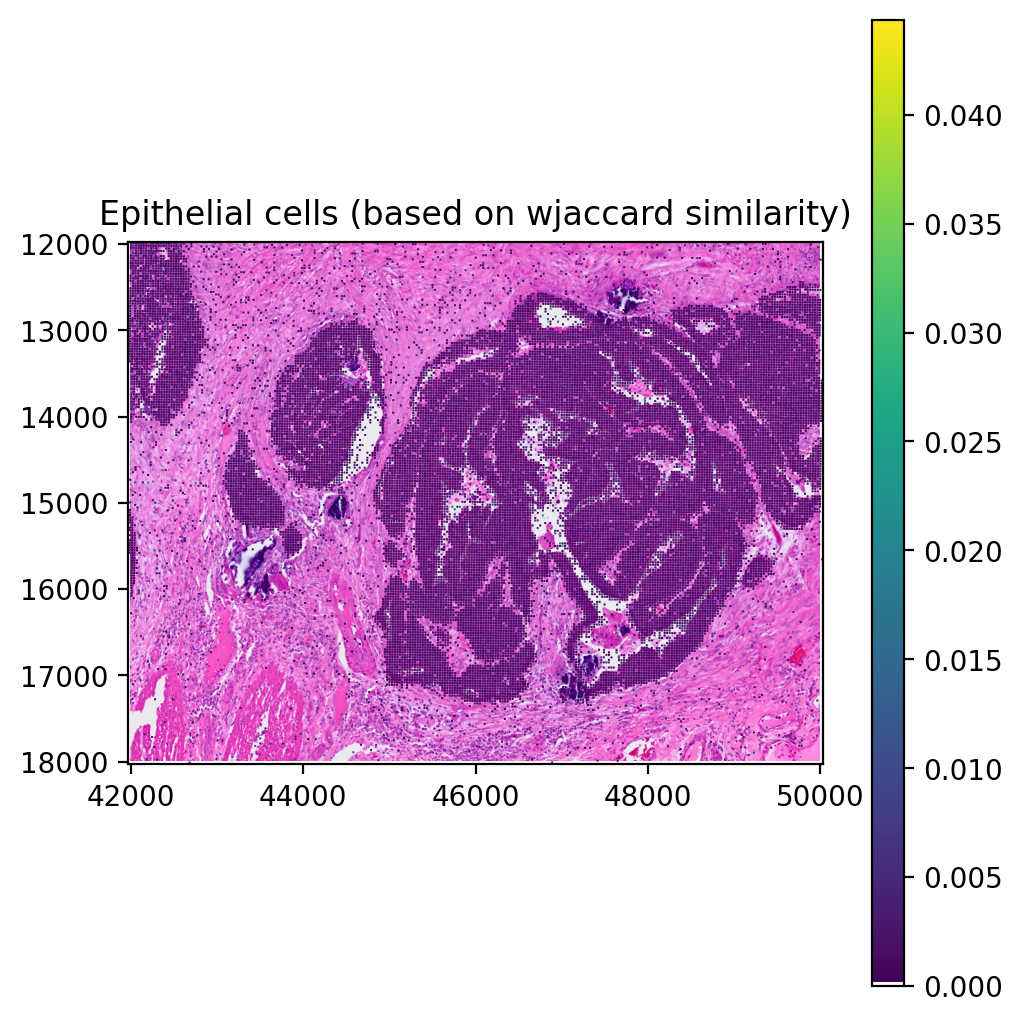

In [21]:

sdata_small.pl.render_images("queried_cytassist").pl.render_shapes(
            f"{sample_id}_square_00{bin_size}um", color="Epi",cmap=new_cmap,method="matplotlib",scale=0.8
        ).pl.show(coordinate_systems="global", title="Epithelial cells (based on wjaccard similarity)", legend_fontsize=8,figsize=(5,5),dpi=200)

We can also assign clusters and write them into a new column in the spatial data object.

In [22]:
assign_clusters_from_df(sdata_small,df_cluster_wjaccard,results_column="easydecon_wjaccard_clusters")

INFO     Using matplotlib                                                                                          


/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:719: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


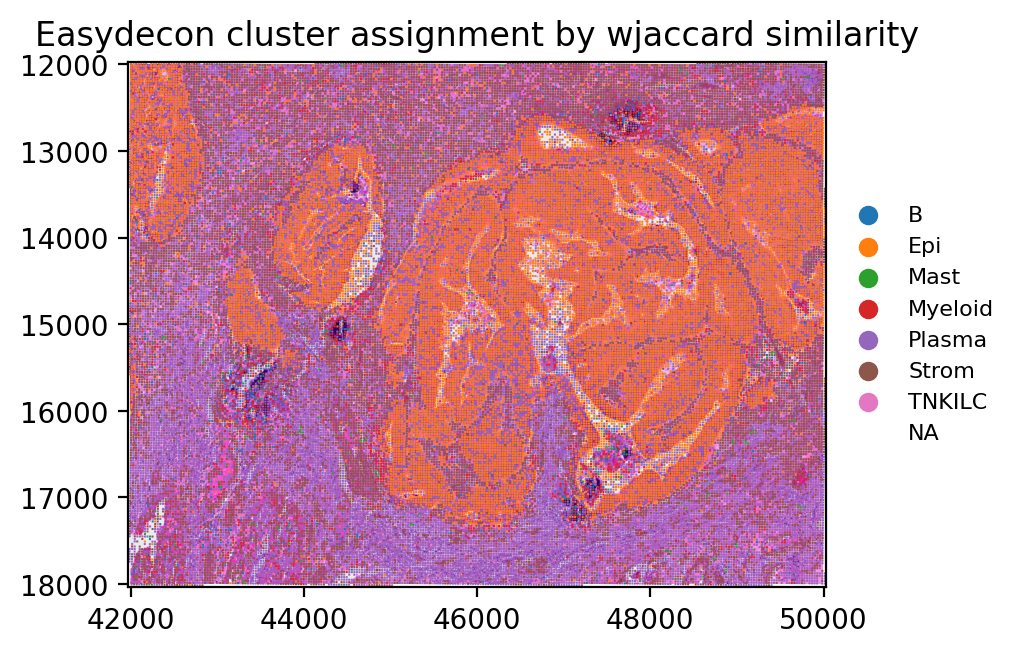

In [23]:
sdata_small.pl.render_images("queried_cytassist").pl.render_shapes(
            f"{sample_id}_square_00{bin_size}um", color="easydecon_wjaccard_clusters",method="matplotlib",scale=0.8,na_color= (0.0, 0.0, 0.0, 0.0)
        ).pl.show(coordinate_systems="global", title="Easydecon cluster assignment by wjaccard similarity", legend_fontsize=8,figsize=(5,5),dpi=200)
